## This notebook creates a table with all the outputs from prospector and the calculates SFR
 date: 21-nov-2022

In [1]:
# dire = '/Users/brian/Library/CloudStorage/OneDrive-UniversityofHertfordshire/DwarfAGN/dwarf_agn/emcee/' # my data
dire = '/Users/brian/Documents/Hertfordshire/dwarf_agn/emcee/' # Ryan's data


The first step is to read in the results into a pandas dataframe, the same can be achieved using the pickle results saved as npy, check these later and compare?

## Getting the Star Formation Rate:
Obtaining the star formation rate requires an estimate of the tage, tau and mass, The star formation rate is the area under the curve of tage and tau, within the mass range of the galaxy in question. For our case we estimate the star formation rate of one of the galaxies in our result.


In [2]:
import prospect.io.read_results as reader
import numpy as np
from scipy.special import gamma, gammainc
from prospect.plotting.corner import quantile
    
results_type = "emcee"
import os

directory = os.fsencode(dire)
import pandas as pd
columns = ['mass', 'dust', 'tage', 'tau', 'fagn', 'agn_tau', 'duste_umin', 'duste_qpah', 'duste_gamma','mass16', 'dust16', 'tage16', 'tau16', 'fagn16', 'agn_tau16', 'duste_umin16', 'duste_qpah16', 'duste_gamma16', 'psi', 'psi1']
a = []


for file in os.listdir(directory):
    filename = os.fsdecode(file)
    
    if filename.endswith(".h5"): 
        # try:
        result, obs, _  = reader.results_from(os.path.join(dire, filename), dangerous=False)

        # Maximum posterior probability sample
        imax = np.argmax(result['lnprobability'])
        csz = result["chain"].shape
        # if result["chain"].ndim > 2:
        # emcee
        i, j = np.unravel_index(imax, result['lnprobability'].shape)
        theta_max = result['chain'][i, j, :].copy()
        flatchain = result["chain"].reshape(csz[0] * csz[1], csz[2])
        #         else:
        #     # dynesty
        # theta_max = result['chain'][imax, :].copy()
        # flatchain = result["chain"]

        # 16th, 50th, and 84th percentiles of the posterior

        weights = result.get("weights", None)

        post_pcts = np.median(flatchain.T,axis=1)
        post_pcts16 = quantile(flatchain.T, q=[0.16, 0.50, 0.84], weights=weights)

        print(post_pcts)
        #----------------------------------------------------------------------------------------
        mass, dust, tage, tau, fagn, agn_tau, duste_umin, duste_qpah, duste_gamma = post_pcts[0],post_pcts[1],post_pcts[2],post_pcts[3],post_pcts[4],post_pcts[5],post_pcts[6],post_pcts[7],post_pcts[8]
        mass16, dust16, tage16, tau16, fagn16, agn_tau16, duste_umin16, duste_qpah16, duste_gamma16 = post_pcts16[0,0],post_pcts16[1,0],post_pcts16[2,0],post_pcts16[3,0],post_pcts16[4,0],post_pcts16[5,0],post_pcts16[6,0],post_pcts16[7,0],post_pcts16[8,0]
        #----------------------------------------------------------------------------------------
        #We calculate the star formation rate:

        tage, tau, mass = post_pcts[2], post_pcts[3], post_pcts[0]
        # for delay tau this function gives the (unnormalized) SFR 
        # for any t, tau combo in M_sun/Gyr
        # sfr = lambda t,tau: return (t/tau) * np.exp(-t/tau)

        sfr = lambda t,tau:(t/tau) * np.exp(-t/tau)
        # now we numerically integrate this SFH from 0 to tage to get the mass formed
        times = np.linspace(0, tage, 1000)
        A = np.trapz(sfr(times, tau), times)
        # But this could also be done using an incomplete gamma function (integral of xe^{-x})
        A = tau * gamma(2) * gammainc(2, tage/tau)
        # and now we renormalize the formed mass to the actual mass value 
        # to get the the SFR in M_sun per Gyr 
        psi = mass * sfr(tage, tau) / A
        # if we want SFR in Msun/year
        psi1 = psi/1e9

        row = mass, dust, tage, tau, fagn, agn_tau, duste_umin, duste_qpah, duste_gamma,mass16, dust16, tage16, tau16, fagn16, agn_tau16, duste_umin16, duste_qpah16, duste_gamma16, psi, psi1,
        a.append(row)
        # except:
        #     print(filename)
            
    
df = pd.DataFrame(a,columns=columns)



[7.04748795e+07 3.66448762e-01 1.08855281e+01 2.19910448e+01
 1.20047793e-03 7.13401787e+00 7.54993625e+00 4.06233190e+00
 3.53188469e-02]
[1.89243722e+08 8.05215920e-02 1.67850988e+00 9.53079088e-01
 4.02640417e-03 1.02136593e+01 1.08922734e+01 4.91998533e+00
 8.56642507e-02]
[4.22571634e+09 2.18714609e-01 2.20646630e+00 5.01511291e-01
 5.46349936e-02 2.10164029e+01 1.18893911e+01 1.12937738e+00
 3.23381606e-02]
[2.88570074e+08 1.74798598e-01 1.00405690e+00 1.45612683e-01
 7.75213013e-04 1.82990613e+01 8.19044952e+00 1.76612023e+00
 2.91090860e-02]
[4.58117346e+07 1.58966383e+00 1.31654993e+00 8.00629976e+00
 3.62353547e-04 1.54945529e+01 1.23015629e+01 7.07490520e-01
 7.72492988e-03]
[1.67788983e+08 4.42700354e-03 1.96592255e+00 6.21290458e-01
 8.48888072e-04 2.26682678e+01 1.09340792e+01 2.72850621e+00
 5.94110767e-02]
[6.03888750e+08 1.44767382e+00 4.62429521e+00 2.42688926e-01
 1.15345172e-01 1.50170029e+01 1.14726420e+01 1.22267811e+00
 1.45745946e-02]
[8.77507546e+08 7.55216596e

In [3]:
rand_pick = np.arange(11000)
rand_pick

array([    0,     1,     2, ..., 10997, 10998, 10999])

In [4]:
rand_pick = np.random.choice(range(len(df['mass'])), 1000)
rand_pick

array([ 561,  195, 1181,  123, 1012,  661,  840, 1325, 1074,  514, 1090,
        270,  357,  736,  174,  801,  250, 1297, 1150,  570,  721, 1252,
        292, 1044,  564,  880,  528,  602,   70, 1270,   10,  120,  999,
        676,   76,  861,  109,   89, 1007, 1147,  350,   37,  981, 1077,
        952,  908,  193,  883,  550, 1173,  445,  184, 1217,  984,  978,
        811, 1306,  322,  826,  397,   44,  457,  921,  822,   19,  383,
       1041,  695,  566,  456, 1033,  410,  546, 1310,  898, 1106,  167,
        241,  917,  132,  474,  845,  986,   86, 1286,  253,  671,  719,
        764, 1116,  941,  351,  943,  745,  613, 1144,  654,  861,  569,
       1012,  316, 1127,  502,  142,    0,  631,  765,  212,  612,  955,
       1067,  717,  680, 1090,  323,  787,  520,  299,  187,  574,  901,
        707,  226, 1000,  304,   43,  901,  560, 1274, 1304,  331,  117,
       1275,  302, 1195,  575,  879,   12,  899,  311,  495,  961,  691,
        939,  464, 1055,  704,  484,  229,  306,  6

In [5]:
result

{'model_params': [{'N': 1,
   'isfree': False,
   'init': 0.1273,
   'units': 'redshift',
   'prior': b'\x80\x02cprospect.models.priors\nTopHat\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05G?\xb9\x99\x99\x99\x99\x99\x9ah\x06G?\xd3333333uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'name': 'zred'},
  {'N': 1,
   'isfree': True,
   'init': 407999846.784471,
   'units': 'Solar masses formed',
   'prior': b'\x80\x02cprospect.models.priors\nLogUniform\nq\x00)\x81q\x01}q\x02(X\x05\x00\x00\x00aliasq\x03}q\x04(X\x04\x00\x00\x00miniq\x05h\x05X\x04\x00\x00\x00maxiq\x06h\x06uX\x06\x00\x00\x00paramsq\x07}q\x08(h\x05GA.\x84\x80\x00\x00\x00\x00h\x06GB\x02\xa0_ \x00\x00\x00uX\x04\x00\x00\x00nameq\tX\x00\x00\x00\x00q\nub.',
   'disp_floor': 100000.0,
   'name': 'mass'},
  {'N': 1,
   'isfree': False,
   'init': -0.5,
   'units': '$\\log (Z/Z_\\odot)$',
   'prior': b'\x80\x02cprosp

In [6]:
obs

{'maggies': array([2.16172637e-10, 3.87080560e-10, 1.08504080e-09, 1.96275354e-09,
        2.46430933e-09, 2.93199780e-09, 3.19442929e-09, 1.66914297e-09,
        1.24902538e-09, 5.46309979e-09, 7.86114952e-10]),
 'maggies_unc': array([1.98763310e-11, 2.93469533e-11, 2.99727835e-12, 4.24226035e-12,
        4.85228463e-12, 7.63773770e-12, 1.64775133e-11, 1.68311785e-11,
        1.40438233e-11, 7.22776153e-10, 2.00713395e-10]),
 'phot_mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]),
 'phot_wave': array([ 1528.05975153,  2271.12579359,  4755.40298706,  6184.09154942,
         7661.32077169,  8896.88932753,  9761.71612297, 35378.51012199,
        44780.55099406, 56962.1965764 , 77980.20467193]),
 'filternames': ['galex_FUV',
  'galex_NUV',
  'hsc_g',
  'hsc_r',
  'hsc_i',
  'hsc_z',
  'hsc_y',
  'spitzer_irac_ch1',
  'spitzer_irac_ch2',
  'spitzer_irac_ch3',
  'spitzer_irac_ch4'],
 'filters': [<class 'sedpy.observate.Filter'>(galex_FUV),


In [7]:
df = pd.DataFrame(a,columns=columns)

In [8]:
def f(row):
    if row['fagn']>0.01:
        val = 'agn'
    else:
        val = 'no_agn'
    return val

In [9]:
df['perc_agn'] = df.apply(f, axis=1)

In [10]:
df_agn =df[df.fagn>0.01]

In [11]:
# bins = np.arange(np.log10(df['mass']).min(), np.log10(df['mass']).max(), 0.3) # adjust as desired

In [12]:
df

,mass,dust,tage,tau,fagn,agn_tau,duste_umin,duste_qpah,duste_gamma,mass16,...,tage16,tau16,fagn16,agn_tau16,duste_umin16,duste_qpah16,duste_gamma16,psi,psi1,perc_agn
0,7.047488e+07,0.366449,10.885528,21.991045,0.001200,7.134018,7.549936,4.062332,0.035319,3.585720e+07,...,0.873395,0.407601,0.000055,5.344786,1.220283,1.625303,0.004247,1.090279e+07,0.010903,no_agn
1,1.892437e+08,0.080522,1.678510,0.953079,0.004026,10.213659,10.892273,4.919985,0.085664,1.707956e+08,...,0.684697,0.142135,0.000124,6.643540,2.492233,3.504769,0.013282,1.143556e+08,0.114356,no_agn
2,4.225716e+09,0.218715,2.206466,0.501511,0.054635,21.016403,11.889391,1.129377,0.032338,2.535131e+09,...,1.122340,0.240327,0.015833,9.195490,3.654334,0.622378,0.005573,4.876408e+08,0.487641,agn
3,2.885701e+08,0.174799,1.004057,0.145613,0.000775,18.299061,8.190450,1.766120,0.029109,2.618180e+08,...,0.784147,0.113609,0.000051,7.155573,1.941751,0.706868,0.003523,1.394649e+07,0.013946,no_agn
4,4.581173e+07,1.589664,1.316550,8.006300,0.000362,15.494553,12.301563,0.707491,0.007725,3.534570e+07,...,0.786247,1.362061,0.000030,7.210000,3.541789,0.547822,0.001820,6.583181e+07,0.065832,no_agn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1322,3.031649e+09,0.121763,6.353532,2.141228,0.000375,55.147044,11.885511,5.555117,0.081770,2.032487e+09,...,2.866728,0.668112,0.000029,14.013732,3.367775,4.614509,0.037899,2.715516e+08,0.271552,no_agn
1323,8.550871e+07,0.000322,3.080749,0.951957,0.000029,6.637200,14.710582,2.176898,0.031490,8.199680e+07,...,2.733925,0.778048,0.000014,5.359109,4.297917,0.897097,0.003343,1.371099e+07,0.013711,no_agn
1324,6.674388e+07,0.002747,6.973611,13.579447,0.000235,53.372962,14.301429,1.469651,0.026319,6.096278e+07,...,5.900593,9.087941,0.000028,11.420057,5.688594,0.630134,0.003402,1.600993e+07,0.016010,no_agn
1325,4.783109e+07,0.564064,2.897502,10.261380,0.013343,24.142047,10.663416,3.051798,0.043941,4.138555e+07,...,1.461189,1.829583,0.000402,7.927751,2.679832,1.170438,0.003965,2.998234e+07,0.029982,agn


In [13]:
# plt.plot(np.log10(df['mean_mass']),np.log10(df['mean_fagn'] ),'o')

In [38]:
# bins = np.arange(np.log10(df['mass']).min(), np.log10(df['mass']).max(), 0.5) # adjust as desired
bins = np.arange(7.0, 10.0, 0.5)
# bins = [0, 1, 5, 10, 25, 50, 100]
df['new_group'] = df.groupby(pd.cut(np.log10(df['mass']), bins, right=False))['fagn'].grouper.group_info[0] + 1

In [39]:
df['logmass'] = np.log10(df.mass)

In [40]:
# I defind the agn sample
df_agn =df[df.fagn>0.01]

# bins = np.arange(np.log10(df_agn['mass']).min(), np.log10(df_agn['mass']).max(), 0.5) # adjust as desired

df_stats2 = pd.DataFrame() # DataFrame for the results
df_stats2['mean_fagn']  = df_agn.groupby(pd.cut(np.log10(df_agn['mass']), bins, right=False)).median()['fagn']
df_stats2['mean_fagn16']  = df_agn.groupby(pd.cut(np.log10(df_agn['mass']), bins, right=False)).median()['fagn16']
df_stats2['mean_mass']  = df_agn.groupby(pd.cut(np.log10(df_agn['mass']), bins, right=False)).median()['mass']
df_stats2['st_dev'] = df_agn.groupby(pd.cut(np.log10(df_agn['mass']), bins, right=False)).std()['fagn']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


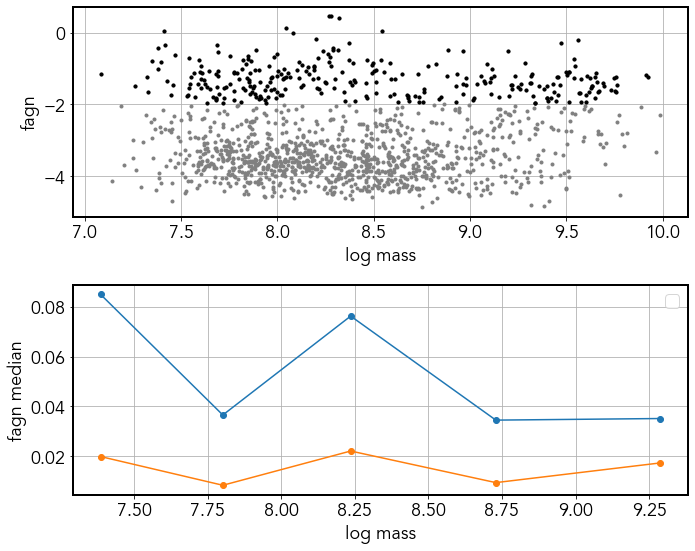

In [41]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize = (10,8))
axs[0].plot(np.log10(df.mass),np.log10(df.fagn),'.',color='grey')
axs[0].plot(np.log10(df_agn.mass),np.log10(df_agn.fagn),'.',color='black')
axs[0].set_xlabel('log mass')
axs[0].set_ylabel('fagn')
axs[0].grid(True)


axs[1].plot(np.log10(df_stats2['mean_mass']),df_stats2['mean_fagn'],'o-')
axs[1].plot(np.log10(df_stats2['mean_mass']),df_stats2['mean_fagn16'],'o-')
axs[1].set_xlabel('log mass')
axs[1].set_ylabel('fagn median')
axs[1].grid(True)

plt.legend()
fig.tight_layout()
plt.show()
# plt.plot(df_agn.mass1,df_agn.fagn,'o')

In [42]:
# bins = np.arange(np.log10(df['mass']).min(), np.log10(df['mass']).max(), 0.2) # adjust as desired

df_stats = pd.DataFrame() # DataFrame for the results
df_stats['mean_mass']  = df.groupby(pd.cut(np.log10(df['mass']), bins, right=False)).median()['mass']
df_stats['log_mean_mass'] = np.log10(df_stats['mean_mass'])
df_stats['agn_mean_sfr']  = df[df['fagn'] > 0.01].groupby(pd.cut(np.log10(df[df['fagn'] > 0.01]['mass']), bins, right=False)).median()['psi1']
df_stats['mean_sfr']    =  df.groupby(pd.cut(np.log10(df['mass']), bins, right=False)).median()['psi1']


In [43]:
df_stats

,mean_mass,log_mean_mass,agn_mean_sfr,mean_sfr
mass,,,,
"[7.0, 7.5)",2.471965e+07,7.393042,0.026511,0.021766
"[7.5, 8.0)",6.463195e+07,7.810447,0.017834,0.011083
"[8.0, 8.5)",1.714905e+08,8.234240,0.023044,0.008339
"[8.5, 9.0)",4.849704e+08,8.685715,0.055743,0.037905
"[9.0, 9.5)",1.647595e+09,9.216850,0.111246,0.140365


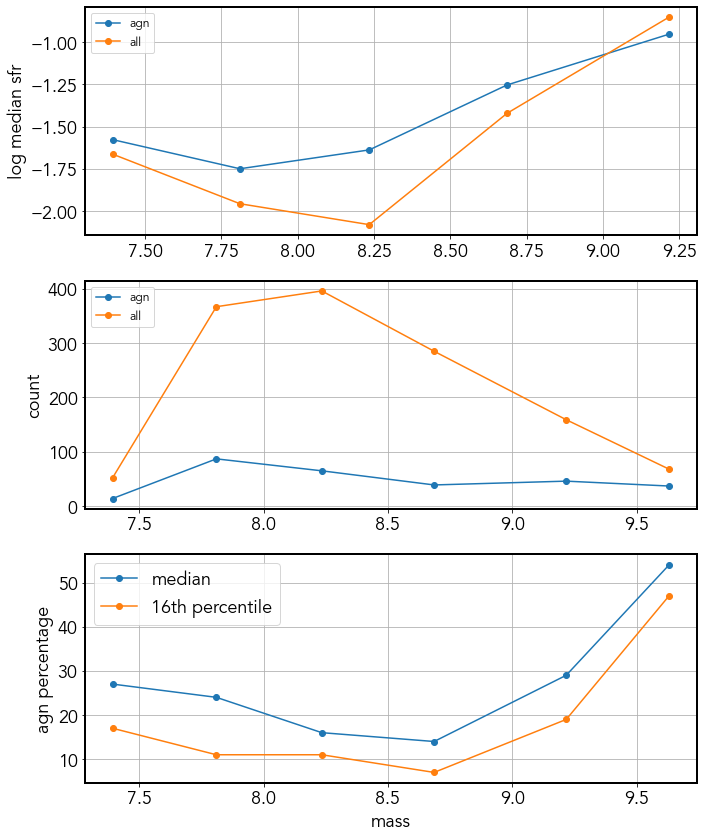

In [50]:
df_stats1 = pd.DataFrame()
df = df.sort_values(by=['mass'])
df_stats1['med_mass'] = df.groupby('new_group')['logmass'].median()
df_stats1['agn_count'] = df[df['fagn'] > 0.01].groupby('new_group')['fagn'].count()
df_stats1['agn_count16'] = df[df['fagn16'] > 0.01].groupby('new_group')['fagn16'].count()
df_stats1['tot_count'] =df.groupby('new_group')['fagn'].count()
df_stats1['tot_count16'] =df.groupby('new_group')['fagn16'].count()
df_stats1['percentage'] = round(df_stats1['agn_count']/df_stats1['tot_count'] * 100)
df_stats1['percentage16'] = round(df_stats1['agn_count16']/df_stats1['tot_count16'] * 100)

df_stats1 = df_stats1.sort_values(by=['med_mass'])

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2




fig, axs = plt.subplots(3, 1, figsize = (10,12))
# axs[0].plot(np.log10(df['mass']),np.log10(df['psi1']),'.')
axs[0].plot(df_stats['log_mean_mass'],np.log10(df_stats['agn_mean_sfr']),'o-',label = 'agn')
axs[0].plot(df_stats['log_mean_mass'],np.log10(df_stats['mean_sfr']),'o-',label = 'all')
# axs[1].set_xlabel('mass')
axs[0].set_ylabel('log median sfr')
axs[0].legend(loc=2,fontsize=12)
axs[0].grid(True)


axs[1].plot(df_stats1['med_mass'],df_stats1['agn_count'],'o-',label = 'agn')
axs[1].plot(df_stats1['med_mass'],df_stats1['tot_count'],'o-',label = 'all')
# axs[0].set_xlabel('mass')
axs[1].set_ylabel('count')
axs[1].grid(True)
axs[1].legend(loc=2,fontsize=12)


axs[2].plot(df_stats1['med_mass'],df_stats1['percentage'],'o-',label = 'median')
axs[2].plot(df_stats1['med_mass'],df_stats1['percentage16'],'o-',label = '16th percentile')
axs[2].set_xlabel('mass')
axs[2].set_ylabel('agn percentage')
axs[2].grid(True)

plt.legend()
fig.tight_layout()
plt.show()

In [48]:
(df[df['fagn'] > 0.01].groupby('new_group')['fagn'].count()/df.groupby('new_group')['fagn'].count()*100).mean()

27.344955541720676

In [46]:
df[df['fagn'] > 0.01].groupby('new_group')['fagn'].count()

new_group
0    37
1    14
2    87
3    65
4    39
5    46
Name: fagn, dtype: int64

In [ ]:
# plt.plot(df.groupby('new_group')['logmass'].median(),df[df['fagn'] > 0.01].groupby('new_group')['fagn'].count()/df.groupby('new_group')['fagn'].count(),'o-')

In [ ]:
bins = [6.0,9.5,10.5,12]

s, edges, _ = binned_statistic(x,y, statistic='mean')

ys = np.repeat(s,2)
xs = np.repeat(edges,2)

data_cut = pd.cut(dfall3.MASS,bins)

grp = dfall3.groupby(by = data_cut)  
grp1 = dfall3.groupby(by = data_cut)  #we group the data by the cut
ret = grp.aggregate(np.mean)        #we produce an aggregate representation (median) of each bin
ret1 = grp.aggregate(np.std) 
# print(ret,ret1)
fig, ax = plt.subplots(figsize=(10,8))
g = sns.scatterplot(dfall3.MASS,np.log10(dfall3['lum_ratio']),style = dfall3.Dust_Lane, hue = dfall3['COLOR(U-V)_bin'], s= 100)
# plt.errorbar(dfall3.MASS,np.log10(dfall3['lum_ratio']),yerr = 0.434*(dfall3['lum_ratio_err']/dfall3['lum_ratio']),fmt=" ",color='lightgrey',zorder=0)



# plt.fill_between(ret.MASS, np.log10(ret.lum_ratio)-0.434*(ret1.lum_ratio/ret.lum_ratio), np.log10(ret.lum_ratio)+0.434*(ret1.lum_ratio/ret.lum_ratio),alpha=0.2,color='grey')
plt.errorbar(ret.MASS,np.log10(ret['lum_ratio']),0.434*(ret1['lum_ratio']/ret['lum_ratio']), elinewidth=2, capthick=2, capsize=4)


In [ ]:
import prospect.io.read_results as reader
import numpy as np
from scipy.special import gamma, gammainc
from prospect.plotting.corner import quantile
    
results_type = "emcee"
import os

directory = os.fsencode(dire)
import pandas as pd
columns = ['mass', 'dust', 'tage', 'tau', 'fagn', 'agn_tau', 'duste_umin', 'duste_qpah', 'duste_gamma', 'psi', 'psi1']
a = []

ii=0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    
    if filename.endswith(".h5"): 
        if ii<10:
            result, obs, _  = reader.results_from(os.path.join(dire, filename), dangerous=False)

            # Maximum posterior probability sample
            imax = np.argmax(result['lnprobability'])
            csz = result["chain"].shape
            # if result["chain"].ndim > 2:
            # emcee
            i, j = np.unravel_index(imax, result['lnprobability'].shape)
            theta_max = result['chain'][i, j, :].copy()
            flatchain = result["chain"].reshape(csz[0] * csz[1], csz[2])
            #         else:
            #     # dynesty
            # theta_max = result['chain'][imax, :].copy()
            # flatchain = result["chain"]

            # 16th, 50th, and 84th percentiles of the posterior

            weights = result.get("weights", None)
            post_pcts = quantile(flatchain.T, q=[0.16, 0.50, 0.84], weights=weights)
            #----------------------------------------------------------------------------------------
            mass, dust, tage, tau, fagn, agn_tau, duste_umin, duste_qpah, duste_gamma = post_pcts[0,1],post_pcts[1,1],post_pcts[2,1],post_pcts[3,1],post_pcts[4,1],post_pcts[5,1],post_pcts[6,1],post_pcts[7,1],post_pcts[8,1]

            #----------------------------------------------------------------------------------------
            #We calculate the star formation rate using

            tage, tau, mass = post_pcts[2,1], post_pcts[3,1], post_pcts[0,1]
            # for delay tau this function gives the (unnormalized) SFR 
            # for any t, tau combo in M_sun/Gyr
            # sfr = lambda t,tau: return (t/tau) * np.exp(-t/tau)

            sfr = lambda t,tau:(t/tau) * np.exp(-t/tau)
            # now we numerically integrate this SFH from 0 to tage to get the mass formed
            
            # times = np.linspace(0, tage, 1000)
            # A = np.trapz(sfr(times, tau), times)
            
            # But this could also be done using an incomplete gamma function (integral of xe^{-x})
            A = tau * gamma(2) * gammainc(2, tage/tau)
            # and now we renormalize the formed mass to the actual mass value 
            # to get the the SFR in M_sun per Gyr 
            psi = mass * sfr(tage, tau) / A
            # if we want SFR in Msun/year
            psi1 = psi/1e9
            print(filename)
            row = mass, dust, tage, tau, fagn, agn_tau, duste_umin, duste_qpah, duste_gamma, psi, psi1
            a.append(row)
            cfig = reader.subcorner(result)
    ii = ii+1
        




In [ ]:
df

In [ ]:
bins = np.arange(-0.00000000000001,9, 5) # adjust as desired
df['mean'] = df.groupby(pd.cut(df['mass'], bins, right=False)).mean()['mass']
df['st_dev'] = df.groupby(pd.cut(df['mass'], bins, right=False)).std()['mass']


In [ ]:
df

In [ ]:
tage, tau, mass = post_pcts[2,1], post_pcts[3,1], post_pcts[0,1]
# for delay tau this function gives the (unnormalized) SFR 
# for any t, tau combo in M_sun/Gyr
# sfr = lambda t,tau: return (t/tau) * np.exp(-t/tau)

sfr = lambda t,tau:(t/tau) * np.exp(-t/tau)
# now we numerically integrate this SFH from 0 to tage to get the mass formed

# times = np.linspace(0, tage, 1000)
# A = np.trapz(sfr(times, tau), times)

# But this could also be done using an incomplete gamma function (integral of xe^{-x})
A = tau * gamma(2) * gammainc(2, tage/tau)
# and now we renormalize the formed mass to the actual mass value 
# to get the the SFR in M_sun per Gyr 
psi = mass * sfr(tage, tau) / A
# if we want SFR in Msun/year
psi1 = psi/1e9